# Интернет-магазин "Стримчик"

Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Данные до 2016 года (сейчас декабрь 2016 г.), планируется кампания на 2017-й.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

### Выгрузка и первичный анализ данных

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import missingno as msno

In [3]:
try:
    games = pd.read_csv('C:/Users/ReeStick/Desktop/yandex/all 1/datasets/games.csv')
except:
    games = pd.read_csv('/datasets/games.csv')
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
games.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

<Axes: >

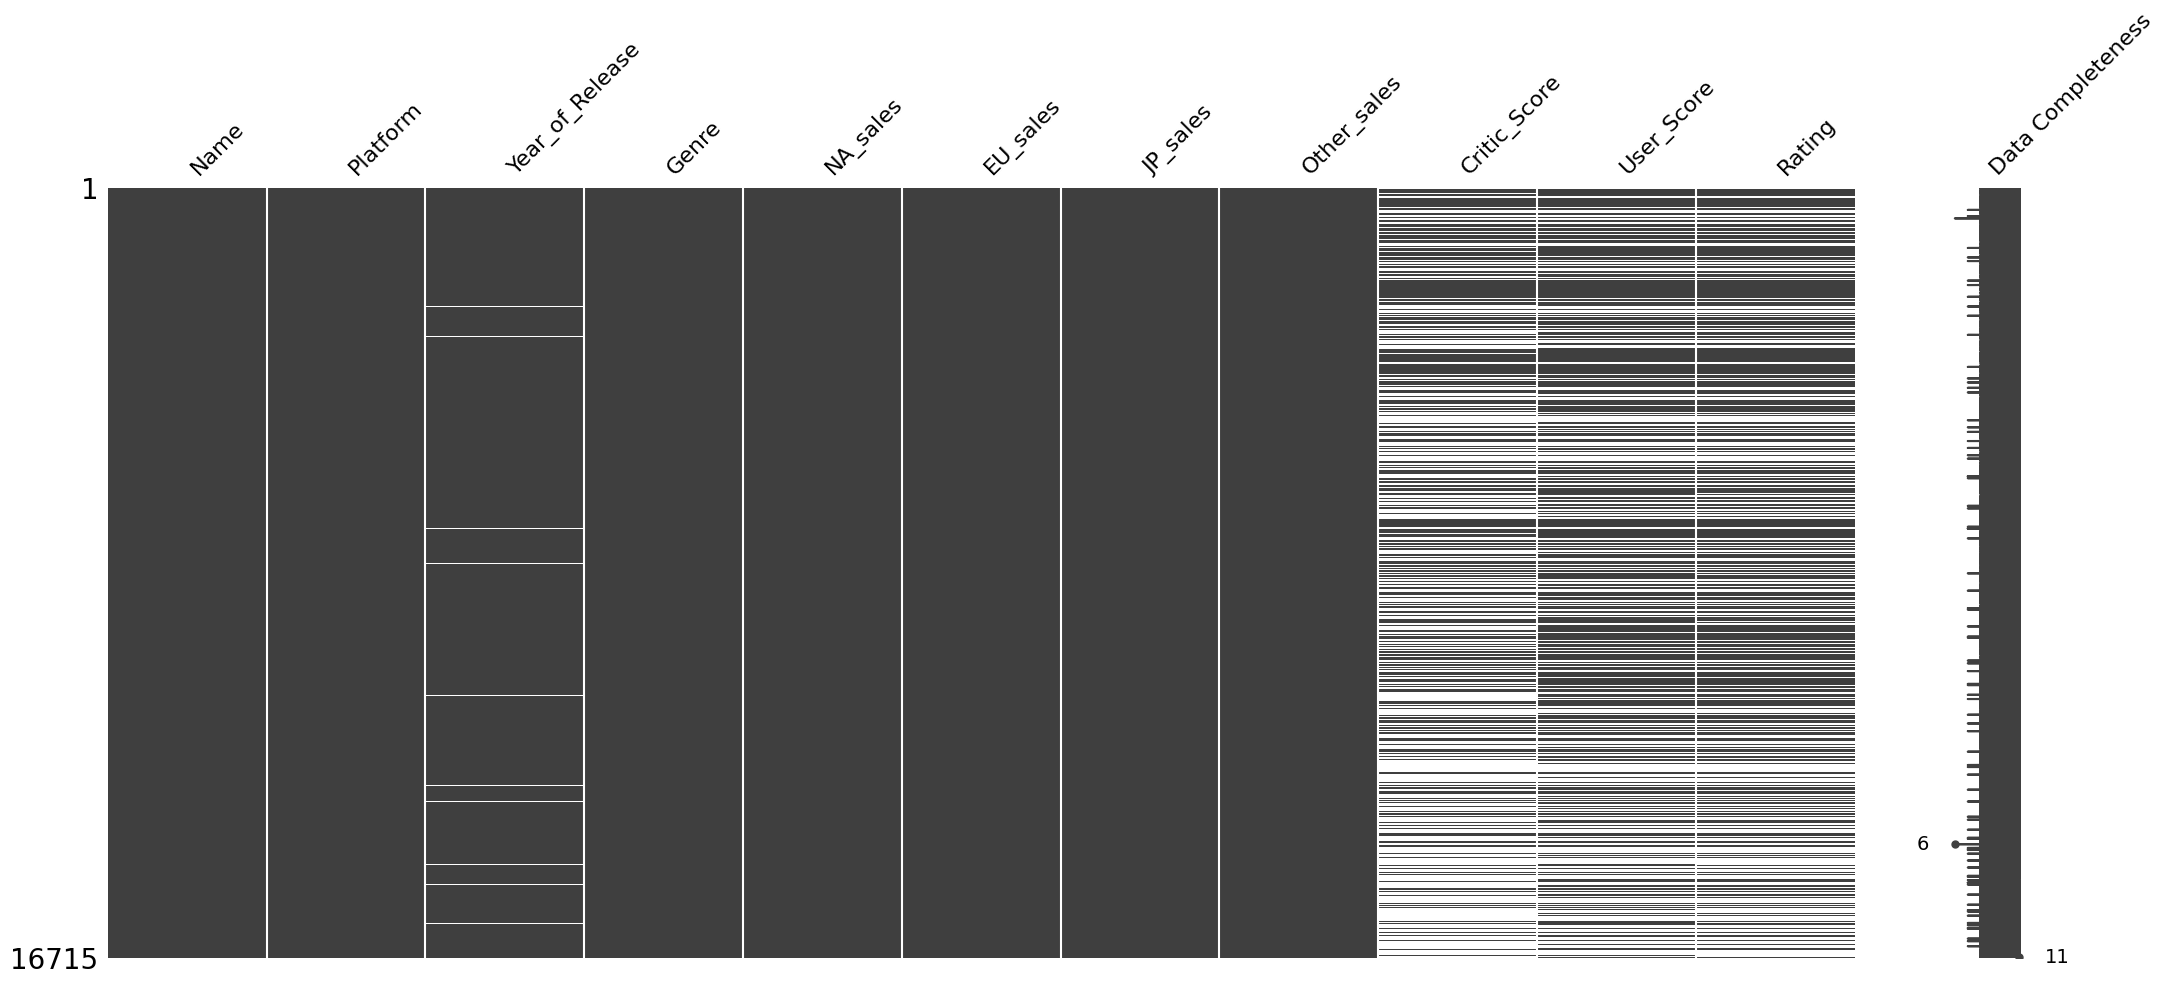

In [6]:
msno.matrix(games, labels=True)

**В данных есть множество пропусков по оценкам критиков и пользователей, а также по возрастному рейтингу. Также есть некоторое количество пропусков с годом релиза.**

### Предобработка данных

In [7]:
# Приведение названий столбцов к нижнему регистру
games.columns = [s.lower() for s in games.columns]
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [8]:
games['user_score'].value_counts()

user_score
tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
1.1       2
1.9       2
9.6       2
0         1
9.7       1
Name: count, Length: 96, dtype: int64

Среди всех столбцов есть user_score с типом object, его нужно привести к float, поскольку это количественные данные, перед этим заменив tbd на NaN, поскольку эта оценка всё ещё не получена. Другие столбцы не нуждаются в замене типа

In [9]:
games.loc[games['user_score'] == 'tbd', 'user_score'] = np.NaN
games['user_score'] = games['user_score'].astype('float')

In [10]:
games.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

Теперь пропусков user_score даже больше чем в critic_score

In [11]:
# Изучение пропущенных данных
games.loc[games['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Данных с пропущеным названием и жанром очень мало, поэтому их можно удалить

In [12]:
games.dropna(subset=['name', 'genre'], inplace=True)

Для того чтобы решить, можно ли заполнить данные об оценках критиков и пользователей, надо посмотреть на их корреляцию с продажами, поскольку это выглядит как единственная релевантная корелляция

In [13]:
games.corr(numeric_only=True)

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score
year_of_release,1.000000,-0.092326,0.004045,-0.168477,0.037821,0.011411,-0.267851
na_sales,-0.092326,1.000000,0.765341,0.449668,0.638695,0.240755,0.086200
eu_sales,0.004045,0.765341,1.000000,0.435079,0.722796,0.220752,0.055337
jp_sales,-0.168477,0.449668,0.435079,1.000000,0.291090,0.152593,0.125598
other_sales,0.037821,0.638695,0.722796,0.291090,1.000000,0.198554,0.057119
critic_score,0.011411,0.240755,0.220752,0.152593,0.198554,1.000000,0.580878
user_score,-0.267851,0.086200,0.055337,0.125598,0.057119,0.580878,1.000000


Судя по таблице, сильную корреляцию имеют только оценки критиков и пользователей между собой, поэтому заполнить их на основе продаж не получится. Возможно оценка будет зависеть от качественных параметров - платформы и жанра

In [14]:
games.pivot_table(values=['critic_score', 'user_score'], index=['platform'], aggfunc=['mean', 'count'])

mean                   count           
         critic_score user_score critic_score user_score
platform                                                
3DS         67.101190   6.831609          168        174
DC          87.357143   8.528571           14         14
DS          63.761506   7.025194          717        516
GBA         67.372146   7.676863          438        255
GC          69.488839   7.597541          448        366
PC          75.928671   7.062468          715        770
PS          71.515000   7.865432          200        162
PS2         68.727273   7.626833         1298       1241
PS3         70.382927   6.726568          820        877
PS4         72.091270   6.748249          252        257
PSP         67.424242   7.228266          462        421
PSV         70.791667   7.336364          120        143
Wii         62.823932   6.742679          585        560
WiiU        70.733333   6.904000           90        100
X360        68.616812   6.683540          916        966
XB          69.859310   7.500512          725        586
XOne        73.325444   6.521429          169        182
2600              NaN        NaN            0          0
3DO               NaN        NaN            0          0
GB                NaN        NaN            0          0
GEN               NaN        NaN            0          0
GG                NaN        NaN            0          0
N64               NaN        NaN            0          0
NES               NaN        NaN            0          0
NG                NaN        NaN            0          0
PCFX              NaN        NaN            0          0
SAT               NaN        NaN            0          0
SCD               NaN        NaN            0          0
SNES              NaN        NaN            0          0
TG16              NaN        NaN            0          0
WS                NaN        NaN            0          0

In [15]:
games.pivot_table(values=['critic_score', 'user_score'], index=['genre'], aggfunc=['mean', 'count'])

mean                   count           
             critic_score user_score critic_score user_score
genre                                                       
Action          66.629101   7.054044         1890       1830
Adventure       65.331269   7.133000          323        300
Fighting        69.217604   7.302506          409        399
Misc            66.619503   6.819362          523        439
Platform        68.058350   7.301402          497        428
Puzzle          67.424107   7.175000          224        128
Racing          67.963612   7.036193          742        641
Role-Playing    72.652646   7.619515          737        743
Shooter         70.181144   7.041883          944        924
Simulation      68.619318   7.134593          352        344
Sports          71.968174   6.961197         1194       1103
Strategy        72.086093   7.295177          302        311

Теперь понятно откуда взялись пропуски - скорее всего по некоторым платформам просто не были собраны данные. Тем не менее, это не хорошая новость, это значит что пропуски заполнить не получится. Удалить строки с пропусками также не вариант - потеряется больше половины данных. Значит остаётся только оставить пропуски. Ещё есть возрастной рейтинг. Поскольку это качественные данные, их можно заполнить заглушкой вроде 'unknown', что я и сделаю

In [16]:
games['rating'].fillna('unknown', inplace=True)

Также есть пропуски в году релиза. Эти пропуски заполнить невозможно, потому что они относятся отдельно к каждой игре, но их немного, поэтому их можно удалить

In [17]:
games.dropna(subset=['year_of_release'], inplace=True)
games.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating                0
dtype: int64

In [18]:
# Создание столбца с продажами
games['all_sales'] = games[['eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,41.18
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,11.16
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,19.84
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,17.16
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,20.11


**Был изменён тип данных user_score: object->float, пропущенные данные оценок пользователей и критиков ничем заполнить не получилось, возрастной рейтинг заполнен 'unknown', были удалены пропуске в столбце выхода игры, жанров и названий, также добавлен столбец с суммарными продажами**

### Исследовательский анализ данных

In [19]:
games.groupby('year_of_release')['year_of_release'].count().sort_values(ascending=False)

year_of_release
2008.0    1427
2009.0    1426
2010.0    1255
2007.0    1197
2011.0    1136
2006.0    1006
2005.0     939
2002.0     829
2003.0     775
2004.0     762
2012.0     653
2015.0     606
2014.0     581
2013.0     544
2016.0     502
2001.0     482
1998.0     379
2000.0     350
1999.0     338
1997.0     289
1996.0     263
1995.0     219
1994.0     121
1993.0      60
1981.0      46
1992.0      43
1991.0      41
1982.0      36
1986.0      21
1989.0      17
1983.0      17
1990.0      16
1987.0      16
1988.0      15
1985.0      14
1984.0      14
1980.0       9
Name: year_of_release, dtype: int64

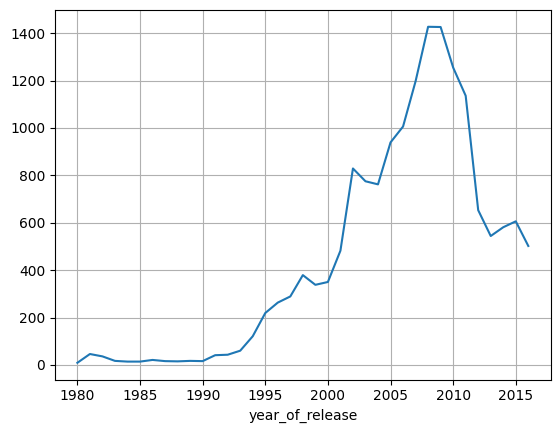

In [20]:
# Сколько игр выпускалось в каждый год
games.groupby('year_of_release')['year_of_release'].count().plot()
plt.grid()
plt.show()

С 1980 по 1993 было выпущено меньше 100 игр в каждый год. Выглядит так, что данные за этот период мало того что не релевантны, так и их слишком мало для статистического анализа, поэтому их можно считать неважными.

In [21]:
# Самые популярные платформы по продажам
platform_sales = pd.pivot_table(
    games,
    index=['platform'],
    values=['all_sales'],
    aggfunc=['sum']
).sort_values(by=('sum', 'all_sales'), ascending=False)
platform_sales.head()

,sum
,all_sales
platform,
PS2,660.64
PS3,541.21
DS,422.47
Wii,404.31
PS,392.86


Наиболее популярными платформами стали playstation 2,3, nintendo Wii и DS, а также xbox360. Также можно рассмотреть популярность платформ в отдельные года.

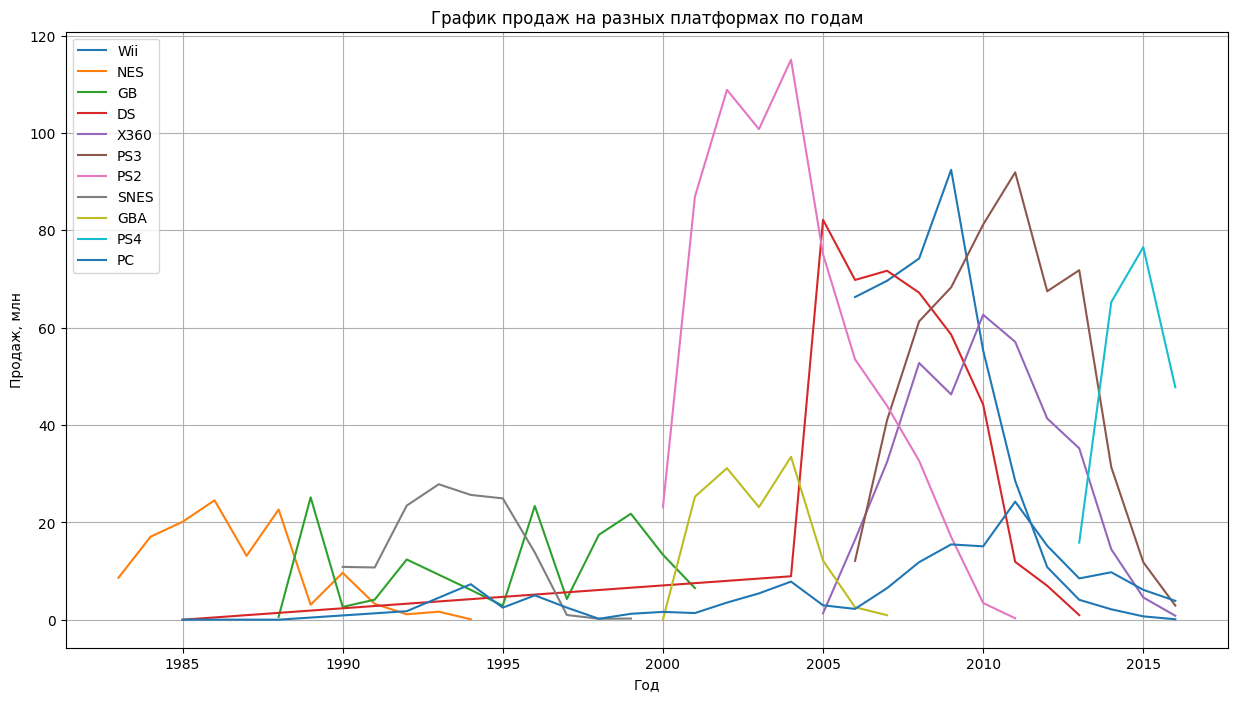

In [22]:
plt.figure(figsize=(15, 8))
for index, platform in enumerate(games['platform'].unique()):
    if index > 9:
        break
    platform_year_sales = pd.pivot_table(
        games[games['platform'] == platform],
        index=['year_of_release'],
        values=['all_sales'],
        aggfunc=['sum']
    )
    plt.plot(platform_year_sales, label=platform)
platform_year_sales = pd.pivot_table(
        games[games['platform'] == 'PC'],
        index=['year_of_release'],
        values=['all_sales'],
        aggfunc=['sum']
)
plt.plot(platform_year_sales, label='PC')
plt.grid()
plt.ylabel('Продаж, млн')
plt.title('График продаж на разных платформах по годам')
plt.xlabel('Год')
plt.legend()
plt.show()

Визуализировано всего 10 платформ, потому что иначе график было бы трудно разобрать. Большинство платформ имеют срок жизни в 6-10 лет, исключая необычные данные по nintendo DS. Видимо это является сроком жизни консоли, и не имеет смысла рассматривать консоли, продажи у которых начались раньше чем в 2005 году. Исключение - PC, поскольку персональные компьютеры имеют постоянное обновление по мощности, в отличии от других консолей где мощность определена заранее производителем.

Следует брать платформы, выпущенные в 2007 год и позже, поскольку данные консолей которые выпущены тогда, всё ещё могут быть релевантными (как было указано ранее, срок жизней консолей составляет до 10 лет, поэтому они всё ещё могут быть релевантны в 2017 году). Актуальный же срок для анализа самих игр - 1-2 года, поскольку если игра не обновлялась или не была обновлена в этот период, о ней либо забывают, либо у неё остаётся устойчивая фанатская база.

In [23]:
# Год выпуска каждой платформы
platform_release = games.groupby('platform')['year_of_release'].min()
# Отсекаем платформы до 2007 года выпуска
relevant_platforms = platform_release.loc[platform_release > 2006]
relevant_platforms

platform
3DS     2011.0
PS4     2013.0
PSV     2011.0
WiiU    2012.0
XOne    2013.0
Name: year_of_release, dtype: float64

Теперь можно построить графики по релевантным платформам (+ПК)

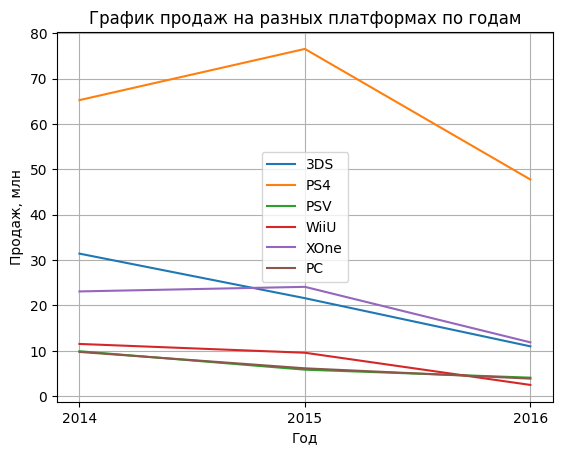

In [24]:
relevant_platforms = relevant_platforms.index.to_list()
# PC релевантен по сей день, поскольку не является стандартной консолью, 
# и не подчиняется напрямую правилу 10 лет
relevant_platforms.extend(['PC'])
# Также нужно сократить года продаж на PC для более правильного сравнения
for platform in relevant_platforms:
    platform_year_sales = pd.pivot_table(
        games[(games['platform'] == platform) & (games['year_of_release'] > 2013)],
        index=['year_of_release'],
        values=['all_sales'],
        aggfunc=['sum']
    )
    plt.xticks([2014, 2015, 2016])
    plt.plot(platform_year_sales, label=platform, )
plt.grid()
plt.ylabel('Продаж, млн')
plt.title('График продаж на разных платформах по годам')
plt.xlabel('Год')
plt.legend()
plt.show()

Судя по графику, определённо нужно учитывать что большую часть рынка занимает PS4. XboxOne и Nintendo 3DS также нужно учитывать, поскольку они занимают соответственно 2 и 3 места по продажам (к тому же Xbox показал рост в 2015 году в отличие от остальных конкурентов не считая PS4). WiiU, PSVita, PC не оказывают большого влияния на рынок, и скорее на них ставку делать не стоит.

In [25]:
# Теперь можно сделать датафрейм только с релевантными платформами (+PC) и играми 2014 и позже года выпуска
relevant_games = games[(games['platform'].isin(relevant_platforms)) & (games['year_of_release'] > 2013)]
relevant_games.reset_index(drop=True, inplace=True)
relevant_games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Call of Duty: Black Ops 3,PS4,2015.0,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,8.60
1,Grand Theft Auto V,PS4,2014.0,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,8.66
2,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014.0,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,unknown,7.33
3,FIFA 16,PS4,2015.0,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,7.46
4,Star Wars Battlefront (2015),PS4,2015.0,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,unknown,4.99


Теперь у нас есть датафрейм только с играми на релевантных платформах. Их можно также сравнить по средней продаваемости игр при помощи boxplot.

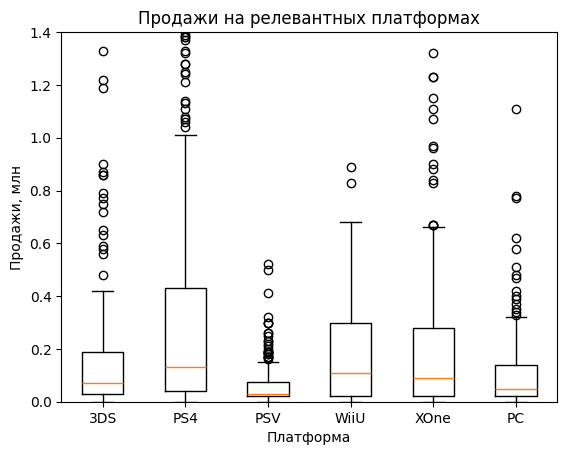

In [26]:
data = []
for platform in relevant_platforms:
    data.append(relevant_games[relevant_games['platform'] == platform]['all_sales'])
# Поскольку есть очень большие значения, график нечитаемый, если не ограничить его сверху
plt.ylim([0,1.4])
plt.title('Продажи на релевантных платформах')
plt.xlabel('Платформа')
plt.ylabel('Продажи, млн')
plt.boxplot(data, labels=relevant_platforms)
plt.show()


Помимо выделенных ранее PS4, 3DS и XboxOne, следует отметить также и Nintendo WiiU. Скорее всего плохой график продаж на ней обусловлен малым количеством хитов (в данном случае это выбросы), но если посмотреть по средним графикам продаж - он даже более популярен чем Nintendo 3DS, новые игры на нём продаются даже стабильнее чем на xbox.

Теперь нужно посмотреть как влияют отзывы пользователей и критиков на продажи. Проще всего рассмотреть это на примере PS4.

In [27]:
# Корреляция параметров
relevant_games.loc[relevant_games['platform'] == 'PS4', ['critic_score', 'user_score', 'all_sales']].corr()

,critic_score,user_score,all_sales
critic_score,1.000000,0.546434,0.368199
user_score,0.546434,1.000000,-0.048639
all_sales,0.368199,-0.048639,1.000000


Продажи немного зависят от оценки критиков, но не зависят от оценок пользователей. Видимо, критики создают некоторую рекламу положительными оценками для игры.

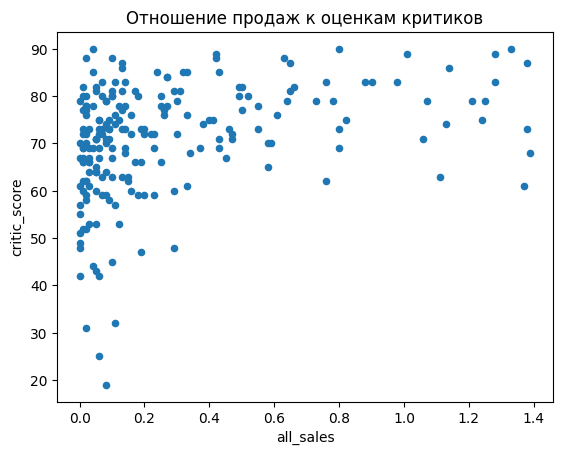

In [28]:
# Диаграмма рассеяния с ограничениями по продажам
relevant_games.loc[(relevant_games['platform'] == 'PS4') & (relevant_games['all_sales'] < 1.4)].plot(kind='scatter', x='all_sales', y='critic_score', title='Отношение продаж к оценкам критиков')
plt.show()

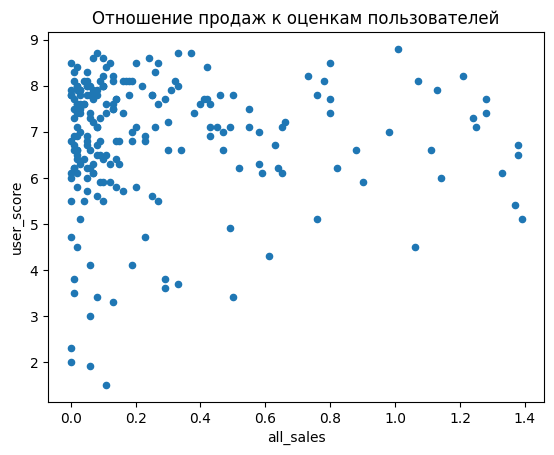

In [29]:
relevant_games.loc[(relevant_games['platform'] == 'PS4') & (relevant_games['all_sales'] < 1.4)].plot(kind='scatter', x='all_sales', y='user_score', title='Отношение продаж к оценкам пользователей')
plt.show()

По диаграммам рассеяния сложно что то сказать, разве что пользователи ставят чаще высокие оценки даже тем играм, которые плохо продаются. В целом, на обоих графиках плохо прослеживается зависимость продаж от оценок. Можно сказать, что от них не зависит насколько хорошо может продаться игра, поскольку если игра получает высокую оценку, это ещё не значит что она будет хорошо продаваться, но у игр с низкой оценкой в обоих случаях, нет шансов на хорошую продажу.

Также можно посмотреть зависимости на других платформах

In [30]:
# Корреляция на XboxOne
relevant_games.loc[relevant_games['platform'] == 'XOne', ['critic_score', 'user_score', 'all_sales']].corr()

,critic_score,user_score,all_sales
critic_score,1.000000,0.440977,0.406189
user_score,0.440977,1.000000,-0.064014
all_sales,0.406189,-0.064014,1.000000


In [31]:
# Корреляция на Nintendo 3DS
relevant_games.loc[relevant_games['platform'] == '3DS', ['critic_score', 'user_score', 'all_sales']].corr()

,critic_score,user_score,all_sales
critic_score,1.000000,0.862485,0.273052
user_score,0.862485,1.000000,0.184303
all_sales,0.273052,0.184303,1.000000


In [32]:
# Корреляция на Nintendo WiiU
relevant_games.loc[relevant_games['platform'] == 'WiiU', ['critic_score', 'user_score', 'all_sales']].corr()

,critic_score,user_score,all_sales
critic_score,1.000000,0.763536,0.363892
user_score,0.763536,1.000000,0.404796
all_sales,0.363892,0.404796,1.000000


In [33]:
# Корреляция на PC
relevant_games.loc[relevant_games['platform'] == 'PC', ['critic_score', 'user_score', 'all_sales']].corr()

,critic_score,user_score,all_sales
critic_score,1.000000,0.466099,0.162320
user_score,0.466099,1.000000,-0.063736
all_sales,0.162320,-0.063736,1.000000


На всех платформах довольно низкая корелляция продаж между оценками и продажами. Но интересно то что на платформах Nintendo оценки пользователей имеют некоторую прямую корреляцию с продажами, в отличие от остальных платформ, где корреляция продаж и оценок пользователей нулевая. Возможно это происходит из-за модерации отзывов - игры nintendo можно оценивать только при наличии игры, поэтому пользователи больше осведомлены о том, чем на самом деле является игра.

Рассмотрим распределение продаж по жанрам

In [34]:
relevant_games.groupby('genre')['all_sales'].sum().sort_values(ascending=False)

genre
Action          107.38
Shooter          78.82
Role-Playing     62.31
Sports           46.00
Racing           17.16
Misc             16.17
Fighting         13.44
Platform         10.69
Simulation       10.06
Adventure         9.52
Strategy          2.92
Puzzle            1.52
Name: all_sales, dtype: float64

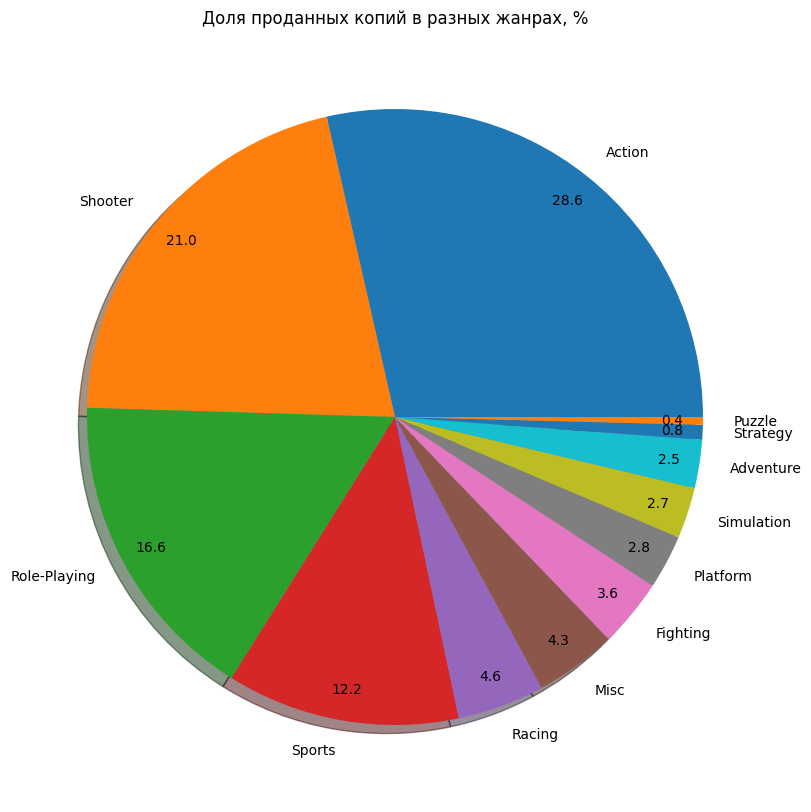

In [35]:
genre_sales = relevant_games.groupby('genre')['all_sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(15, 10))
plt.pie(genre_sales, labels=genre_sales.index, autopct='%.1f', shadow=True, pctdistance=0.9)
plt.title('Доля проданных копий в разных жанрах, %')
plt.show()

В сумме, на всех 6 платформах больше 100 млн копий было продано в жанрах экшн, шутеров, РПГ, спортивных. Меньше всего было продано копий в жанрах стратегий, головоломок и приключений - не больше 20 млн копий в каждой. Теперь посмотрим, сколько всего было издано игр по этим жанрам.

In [36]:
relevant_games.groupby('genre')['all_sales'].count().sort_values(ascending=False)

genre
Action          495
Role-Playing    187
Adventure       148
Sports          104
Shooter          99
Misc             89
Racing           53
Simulation       40
Fighting         38
Strategy         36
Platform         33
Puzzle           13
Name: all_sales, dtype: int64

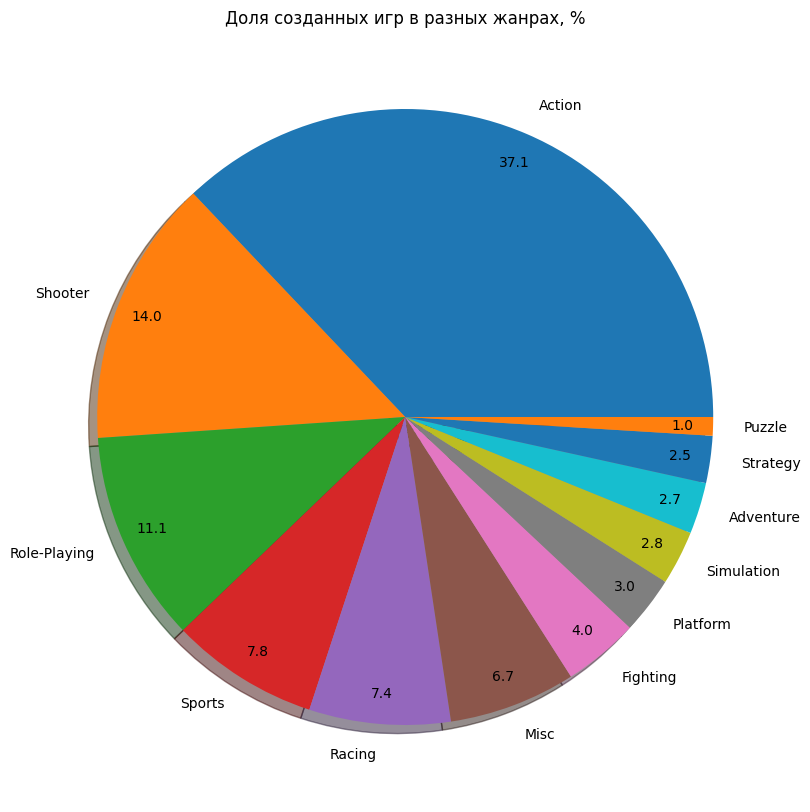

In [37]:
genre_games = relevant_games.groupby('genre')['all_sales'].count().sort_values(ascending=False)
plt.figure(figsize=(15, 10))
plt.pie(genre_games, labels=genre_sales.index, autopct='%.1f', shadow=True, pctdistance=0.9)
plt.title('Доля созданных игр в разных жанрах, %')
plt.show()

В целом графики похожи, разве что экшн игр делается очень много. Стоит также посмотреть по другим статистическим данным: медианные и средние продажи

In [38]:
# Средние продажи игр, млн
relevant_games.groupby('genre')['all_sales'].mean().sort_values(ascending=False)

genre
Shooter         0.796162
Sports          0.442308
Fighting        0.353684
Role-Playing    0.333209
Platform        0.323939
Racing          0.323774
Simulation      0.251500
Action          0.216929
Misc            0.181685
Puzzle          0.116923
Strategy        0.081111
Adventure       0.064324
Name: all_sales, dtype: float64

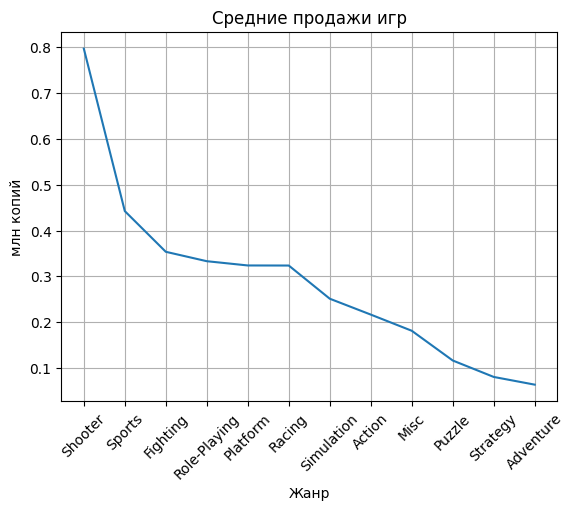

In [39]:
plt.plot(relevant_games.groupby('genre')['all_sales'].mean().sort_values(ascending=False))
plt.xticks(rotation=45)
plt.title('Средние продажи игр')
plt.xlabel('Жанр')
plt.ylabel('млн копий')
plt.grid()
plt.show()

In [40]:
# Медианные продажи игр, млн
relevant_games.groupby('genre')['all_sales'].median().sort_values(ascending=False)

genre
Shooter         0.290
Sports          0.120
Fighting        0.090
Role-Playing    0.090
Misc            0.070
Platform        0.070
Simulation      0.070
Action          0.060
Racing          0.060
Strategy        0.055
Puzzle          0.030
Adventure       0.025
Name: all_sales, dtype: float64

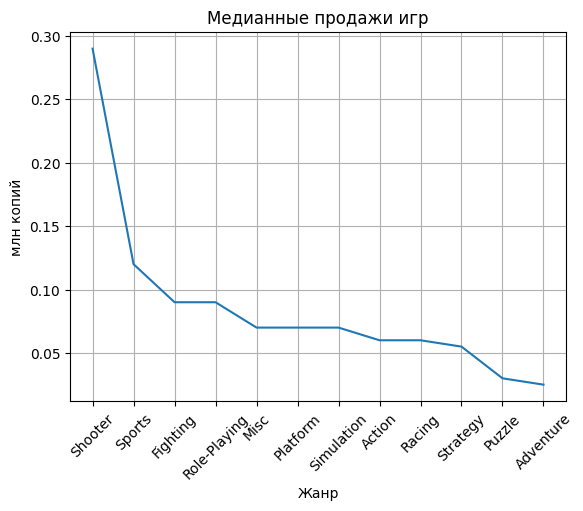

In [41]:
plt.plot(relevant_games.groupby('genre')['all_sales'].median().sort_values(ascending=False))
plt.xticks(rotation=45)
plt.title('Медианные продажи игр')
plt.xlabel('Жанр')
plt.ylabel('млн копий')
plt.grid()
plt.show()

Сравнивая с графиками выше, экшн игры продаются в среднем не очень хорошо, но их делают много, и некоторые из них выстреливают. Самые стабильные игры по продажам - шутеры, спортивные, файтинги (даже при том что их общая выручка мала) и РПГ.

**Срок жизни консолей состовляет около 7-10 лет, поэтому в исследовании учитываются только PS4, XboxOne, Nintendo 3DS, Nintendo WiiU, PS Vita и вышедшие в 2007 году и позже игры на ПК. Оценки пользователей и критиков незначительно связаны с продажами игр, если рассматривать игры на платформах не выпущенных Nintendo - зависимость продаж от оценок пользователей нулевая, из-за того что игру nintendo нельзя оценить, не приобретая её. Самые популярные жанры по общим продажам - экшн, рпг и шутеры, самые непопулярные - головоломки, стратегии и приключения. При этом стабильнее всего продаются шутеры, спортивные и файтинги, наименее стабильно - головоломки, приключения и стратегии, как и в общих продажах.**

### Портреты пользователей в разных регионах.

Сравним несколько пунктов в разных регионах: популярность платформ, жанров, и влияние возрастного рейтинга на продажи

In [42]:
# Популярные платформы в Северной Америке
relevant_games.groupby('platform')['na_sales'].sum().sort_values(ascending=False).head(5)

platform
PS4     98.61
XOne    81.27
3DS     22.64
WiiU    19.36
PC       7.23
Name: na_sales, dtype: float64

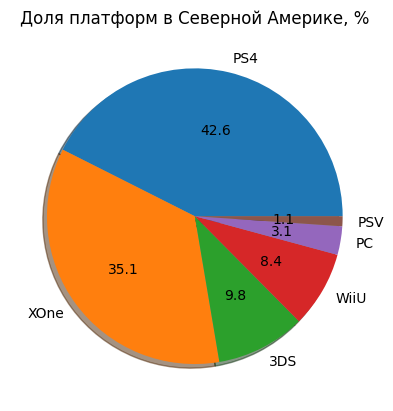

In [43]:
na_platforms = relevant_games.groupby('platform')['na_sales'].sum().sort_values(ascending=False)
plt.pie(na_platforms, labels=na_platforms.index, autopct='%.1f', shadow=True)
plt.title('Доля платформ в Северной Америке, %')
plt.show()

In [44]:
# Популярные платформы в Европе
relevant_games.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).head(5)

platform
PS4     130.04
XOne     46.25
PC       17.97
3DS      16.12
WiiU     13.15
Name: eu_sales, dtype: float64

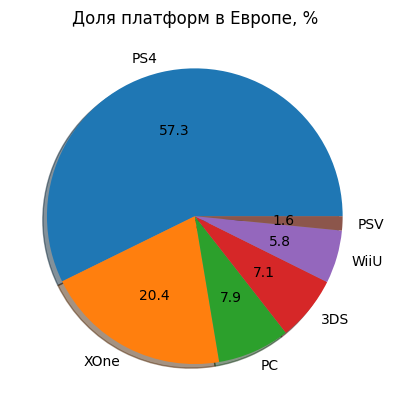

In [45]:
eu_platforms = relevant_games.groupby('platform')['eu_sales'].sum().sort_values(ascending=False)
plt.pie(eu_platforms, labels=eu_platforms.index, autopct='%.1f', shadow=True)
plt.title('Доля платформ в Европе, %')
plt.show()

In [46]:
# Популярные платформы в Японии
relevant_games.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).head(5)

platform
3DS     44.24
PS4     15.02
PSV     14.54
WiiU     7.31
XOne     0.32
Name: jp_sales, dtype: float64

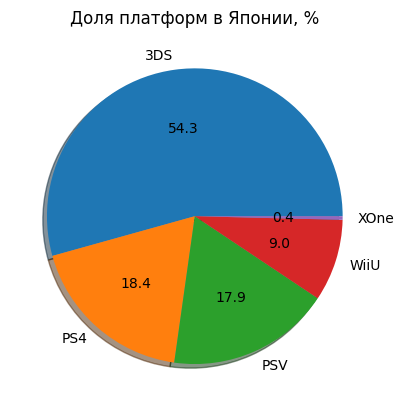

In [47]:
jp_platforms = relevant_games.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).head(5)
plt.pie(jp_platforms, labels=jp_platforms.index, autopct='%.1f', shadow=True)
plt.title('Доля платформ в Японии, %')
plt.show()

Text(0, 0.5, 'Кол-во проданных копий, млн')

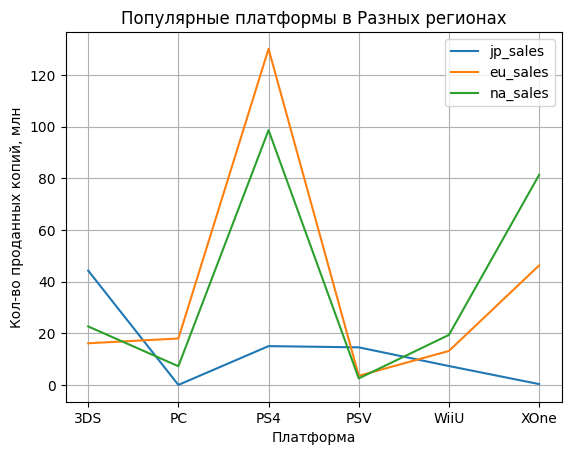

In [48]:
for region in ['jp_sales', 'eu_sales', 'na_sales']:
    plt.plot(relevant_games.groupby('platform')[region].sum(), label=region)
plt.title('Популярные платформы в Разных регионах')
plt.legend()
plt.grid()
plt.xlabel('Платформа')
plt.ylabel('Кол-во проданных копий, млн')

Продажи в Европе и Америке отличаются незначительно - Персональный компьютер популярнее в Европе, Xbox - в Америке, общий уклон идёт в сторону стационарных консолей. Но рынок Японии сильно отличается - самые большие продажи у портативных консолей, таких как Nintendo 3DS и PS Vita.

In [49]:
# Популярные жанры в Америке
relevant_games.groupby('genre')['na_sales'].sum().sort_values(ascending=False).head(5)

genre
Shooter         66.29
Action          60.16
Sports          31.96
Role-Playing    29.74
Fighting        11.23
Name: na_sales, dtype: float64

Text(0.5, 1.0, 'Доля жанров в Северной Америке, %')

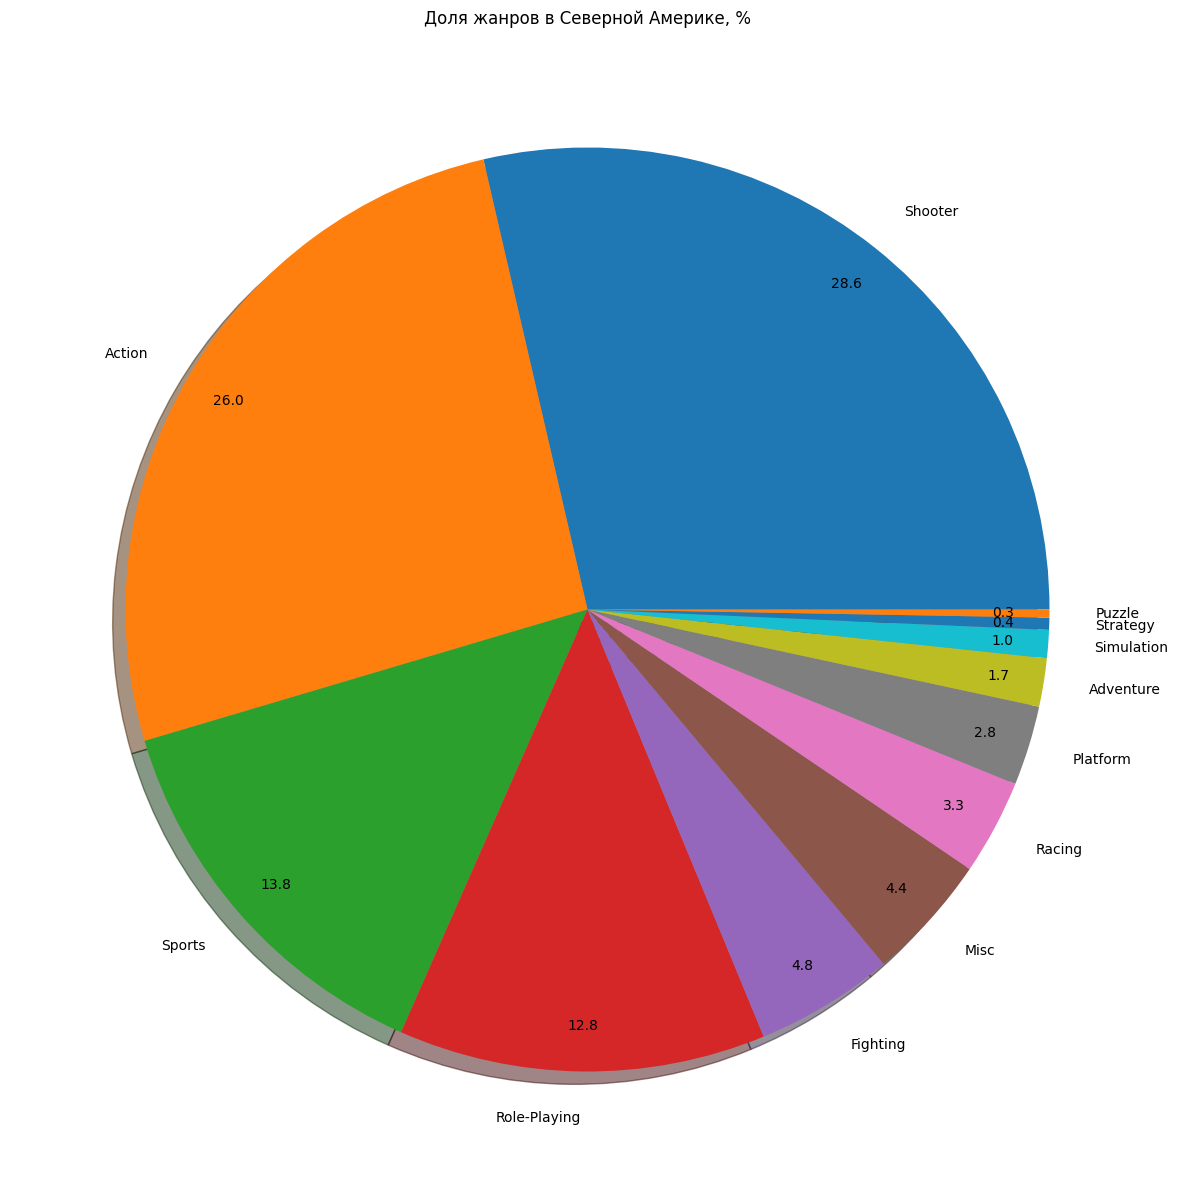

In [50]:
na_genres = relevant_games.groupby('genre')['na_sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(15, 15))
plt.pie(na_genres, labels=na_genres.index, autopct='%.1f', shadow=True, pctdistance=0.9)
plt.title('Доля жанров в Северной Америке, %')

In [51]:
# Популярные жанры в Европе
relevant_games.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).head(5)

genre
Action          63.49
Shooter         56.23
Sports          33.48
Role-Playing    25.94
Racing          12.92
Name: eu_sales, dtype: float64

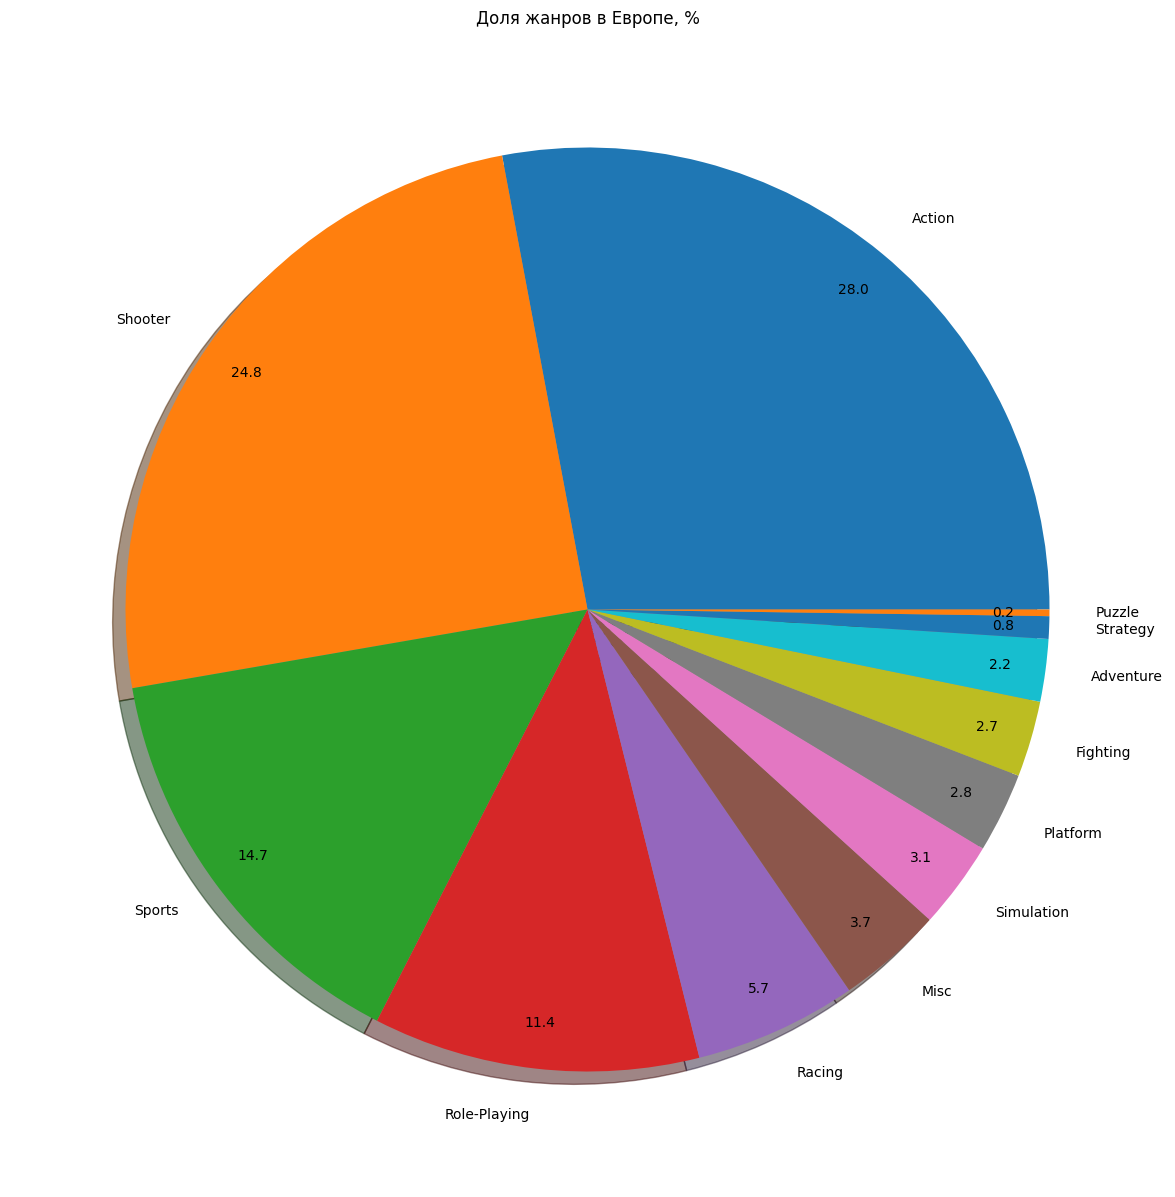

In [52]:
eu_genres = relevant_games.groupby('genre')['eu_sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(15, 15))
plt.pie(eu_genres, labels=eu_genres.index, autopct='%.1f', shadow=True, pctdistance=0.9)
plt.title('Доля жанров в Европе, %')
plt.show()

In [53]:
# Популярные жанры в Японии
relevant_games.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).head(5)

genre
Role-Playing    28.70
Action          24.71
Misc             5.17
Fighting         5.01
Shooter          4.21
Name: jp_sales, dtype: float64

Text(0.5, 1.0, 'Доля жанров в Японии, %')

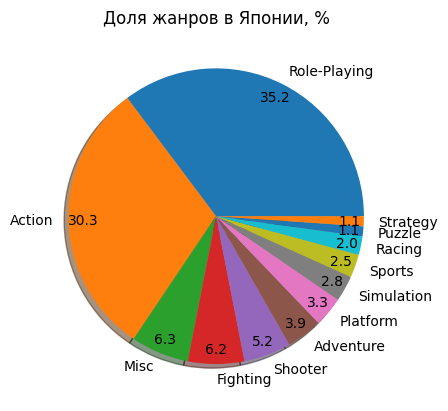

In [54]:
jp_genres = relevant_games.groupby('genre')['jp_sales'].sum().sort_values(ascending=False)
plt.pie(jp_genres, labels=jp_genres.index, autopct='%.1f', shadow=True, pctdistance=0.9)
plt.title('Доля жанров в Японии, %')

Различия в популярности жанров Европы и Америки начинаются лишь с 5 места, в целом эти регионы похожи друг на друга, в то время как в Японии, РПГ игры превосходят по популярности экшн, в то время как шутеры вовсе не находятся в топ5.

In [55]:
# Продажи с различными возрастными рейтингами в Америке
(relevant_games[relevant_games['rating'] != 'unknown']
    .groupby('rating')['na_sales']
    .sum()
    .sort_values(ascending=False)
)

rating
M       82.23
E       37.65
T       32.46
E10+    23.53
Name: na_sales, dtype: float64

Text(0.5, 1.0, 'Доля продаж по возрастному рейтингу в Америке, %')

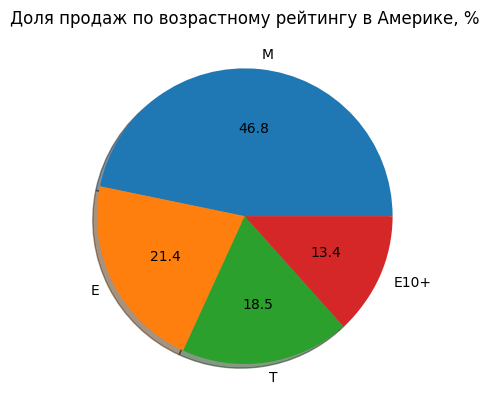

In [56]:
na_rating = (relevant_games[relevant_games['rating'] != 'unknown']
    .groupby('rating')['na_sales']
    .sum()
    .sort_values(ascending=False)
    .head(4)
)
plt.pie(na_rating, labels=na_rating.index, autopct='%.1f', shadow=True)
plt.title('Доля продаж по возрастному рейтингу в Америке, %')

In [57]:
# Продажи с различными возрастными рейтингами в Европе
(relevant_games[relevant_games['rating'] != 'unknown']
    .groupby('rating')['eu_sales']
    .sum()
    .sort_values(ascending=False)
)

rating
M       82.38
E       45.90
T       30.09
E10+    17.89
Name: eu_sales, dtype: float64

Text(0.5, 1.0, 'Доля продаж по возрастному рейтингу в Европе, %')

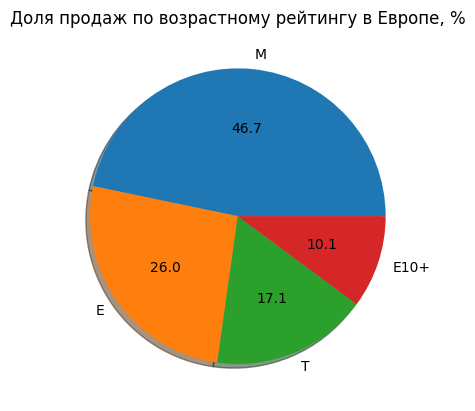

In [58]:
eu_rating = (relevant_games[relevant_games['rating'] != 'unknown']
    .groupby('rating')['eu_sales']
    .sum()
    .sort_values(ascending=False)
    .head(4)
)
plt.pie(eu_rating, labels=eu_rating.index, autopct='%.1f', shadow=True)
plt.title('Доля продаж по возрастному рейтингу в Европе, %')

In [59]:
# Продажи с различными возрастными рейтингами в Японии
(relevant_games[relevant_games['rating'] != 'unknown']
    .groupby('rating')['jp_sales']
    .sum()
    .sort_values(ascending=False)
)

rating
T       11.99
E        8.29
M        6.40
E10+     4.32
Name: jp_sales, dtype: float64

Text(0.5, 1.0, 'Доля продаж по возрастному рейтингу в Японии, %')

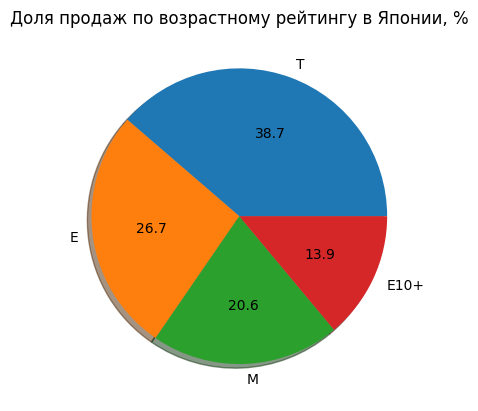

In [60]:
jp_rating = (relevant_games[relevant_games['rating'] != 'unknown']
    .groupby('rating')['jp_sales']
    .sum()
    .sort_values(ascending=False)
    .head(4)
)
plt.pie(jp_rating, labels=jp_rating.index, autopct='%.1f', shadow=True)
plt.title('Доля продаж по возрастному рейтингу в Японии, %')

В Японии не так популярны игры с рейтингом M, они занимают 3 место по продажам, в отличие от Америки, и Европы, где игры с рейтингом M продаются чаще других.

**Америка и Европа - схожие рынки по многим параметрам: популярность платформ (не считая ПК и Xbox), популярные жанры (экшн, затем рпг, шутеры), и даже покупки по возрастному рейтингу. Японский рынок кардинально отличается - на нём популярны портативные, а не стационарные консоли, самый популярный жанр - РПГ, а шутеры в Японии вовсе не особо популярны. К тому же в Японии хуже продаются игры с рейтингом M**

### Проверка гипотез

**1-я гипотеза** Средние пользовательские оценки на Xbox One и PC одинаковые. Пользователи этих двух платформ примерно одни и те же, поэтому дисперсию выборок можно считать равной. Тогда, поскольку нам нужно доказать равенство, или неравенство средних оценок, нулевая и альтернативная гипотезы выглядят следующим образом:

$H_0: \mu_1 = \mu_2$

$H_1: \mu_1 \neq \mu_2$

Где $\mu_1, \mu_2$ - выборочные средние Xbox и PC

Проверим гипотезу:

In [61]:
pc_ratings = relevant_games[relevant_games['platform'] == 'PC']['user_score'].dropna()
xbox_ratings = relevant_games[relevant_games['platform'] == 'XOne']['user_score'].dropna()

# Поскольку точность результата некритична, лучше установить пороговую степень значимости в 5%
alpha = .05

results = st.ttest_ind(pc_ratings, xbox_ratings)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 0.10450507919348415
Не отвергаем нулевую гипотезу


Да, пользователи одинаково оценивают игры на Xbox One и ПК

**2-я гипотеза** Средние пользовательские оценки жанров экшн и спортивных игр разные. Оценки спортивных игр могут очень отличаться друг от друга, быть как высокими, так и низкими, в то время как оценки жанра экшн чаще всего положительные, дисперсию стоит считать разной. Тогда, поскольку нам нужно доказать равенство, или неравенство средних оценок, нулевая и альтернативная гипотезы выглядят следующим образом:

$H_0: \mu_1 = \mu_2$

$H_1: \mu_1 \neq \mu_2$

Проверим гипотезу:

In [62]:
action_ratings = relevant_games[relevant_games['genre'] == 'Action']['user_score'].dropna()
sports_ratings = relevant_games[relevant_games['genre'] == 'Sports']['user_score'].dropna()

# Поскольку точность результата некритична, лучше установить пороговую степень значимости в 5%
alpha = .05

results = st.ttest_ind(action_ratings, sports_ratings, equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 1.1664151897936176e-08
Отвергаем нулевую гипотезу


Да, в среднем, пользовательские оценки игр жанра экшн и спортивных игр, разные.

**В среднем, игры на Xbox One и PC оцениваются одинаково. Также, в среднем у игр жанра экшн и спорт разные оценки.**

### Общий вывод

В этой работе рассматривались 6 релевантных платформ: Nintendo 3DS, Nintendo WiiU, PS Vita, PS4, Xbox One, PC (с играми 2007 и позже года выпуска). Остальные платформы не учитывались, поскольку они уже нерелевантны для анализа на 2017 год. Исходя из анализа самих данных сделаны следующие выводы:
* 3 самые популярные платформы по продажам игр - PS4, с большим отрывом, затем 3DS и Xbox, и потом все остальные. 
* В среднем хорошо продаются игры на таких платформах, как PS4, Xbox, WiiU, 3DS. PS4 также лидирует в этом наблюдении с отрывом
* Оценки критиков и пользователей на консолях Nintendo имеют некоторую зависимость с продажами игр. В то же время, оценки пользователей не на консолях Nintendo никак не соотносятся с продажами.
* Самыми популярными жанрами по общим продажам являются экшн, РПГ, шутеры, самыми непопулярными явлются головоломки, приключения, стратегии. Самыми стабильными по средним продажам являются шутеры, РПГ, файтинги, спортивные.

Стоит отдельно отметить, что Японский рынок сильно отличается от Европейского и Американского, которые не сильно различаются между собой. На Японском рынке доминируют портативные консоли, в то время как в Европе и Америке - стационарные. Также, в Японии непопулярны шутеры, и первое место по продажам занимают РПГ, на втором месте экшн, и в общем, в Японии непопулярны игры возрастного рейтинга M, которые популярны в Европе и Америке.

Также были подтверждены следующие гипотезы - в среднем, оценки игр на PC и Xbox One одинаковые; в среднем оценки игр жанров экшн и спорта разные.

В зависимости от приоритетного направления продажи нужно подстраиваться под региональный рынок, поскольку в Европе популярны PC, а в Америке Xbox One, но в целом эти рынки похожи, так что популярная игра в одном регионе, скорее всего станет популярной и в другом (Крайне рекомендуется сделать упор на игры PS4 на этом рынке), возможно, с упором на более детские игры. В Японии нужен кардинально другой подход, с ориентацией на  игры для всех возрастов на портативных консолях. Наиболее предпочтительные жанры: шутеры (не на японском рынке), РПГ, файтинги, спортивные игры.

Это относительно полное исследование для анализа продаж на 2017 год, но возможно стоит провести анализ со всеми имеющимеся данными, для понимания исторического контекста различных рынков, и планировки долгосрочной стратегии на основе этого анализа. Всё же цикл разработки игры составляет от 3 до 5 лет, среднесрочная и долгосрочная стратегии крайне важны на рынке компьютерных игр.
